In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.layers import Input, LSTM, Dense, Dropout
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, classification_report

# Introduction
Energy investors often hold futures contracts. Natural gas futures are a common energy investment, held by both individuals and various business entities. These are, as other futures contracts, legally enforceable promises to buy gas in the future at a given price. Put otherwise, a futures contract is, for the buyer, essentially a bet that gas will be worth more than the contract price at the time of purchase. Alternatively, aan investor such as an energy company might use a futures contract to hedge their interest in the price of natural gas.

Whether used as an investment itself or a means of hedging, the holder of a natural gas futures contract has a strong interest in predicting price changes in the natural gas market. In this notebook, an LSTM model is trained to predict such price changes.

The data used is from [this](https://www.kaggle.com/datasets/psycon/historical-natural-gas-data-from-2000-to-202204) dataset. I discuss an issue with the dataset below. 

# Load Data
The data has the following features:
* Date
* Open price
* Close price
* Low price
* Volume (MMBtu)
Note that while not provided by the dataaset, the units for volume are likely million British thermal units or MMBtus. This is a standard unit. Similarly, prices for natural gas contracts are often given in dollars per MMBtu. When so presented, the values are similar to the ones listed here (see, e.g. [here](eia.gov/dnav/ng/hist/rngc1d.htm)).

In [3]:
df = pd.read_csv('natural_gas.csv')
df.head()

,Date,Open,High,Low,Close,Volume,Currency
0,2000-01-04,2.130,2.200,2.130,2.176,30152,USD
1,2000-01-05,2.180,2.200,2.125,2.168,27946,USD
2,2000-01-06,2.165,2.220,2.135,2.196,29071,USD
3,2000-01-07,2.195,2.230,2.155,2.173,28455,USD
4,2000-01-10,2.180,2.255,2.165,2.216,28916,USD


In [4]:
df['Date'] = pd.to_datetime(df['Date'])

In [5]:
df.Currency.unique()

array(['USD'], dtype=object)

The Currency feature is dropped, since all currencies are USD.

In [6]:
df.drop('Currency', errors='ignore', inplace=True, axis=1)
df.head(), df.shape

(        Date   Open   High    Low  Close  Volume
 0 2000-01-04  2.130  2.200  2.130  2.176   30152
 1 2000-01-05  2.180  2.200  2.125  2.168   27946
 2 2000-01-06  2.165  2.220  2.135  2.196   29071
 3 2000-01-07  2.195  2.230  2.155  2.173   28455
 4 2000-01-10  2.180  2.255  2.165  2.216   28916,
 (5708, 6))

# Feature Engineering
I simply add features for a "Change" feature which is the change from the previous day's high price and a "Change Sign" feature which determines if the change was positive, negative or zero.

In [7]:
current_price = df['High'].values[1:]
previous_price = df['High'].values[:-1]
delta =  [current_price - previous_price]
delta = np.insert(delta, 0,0)
delta_sign = [d/np.abs(d) if d != 0 else d for d in delta]

df['Change'] = delta
df['Change Sign'] = delta_sign
df.head()

,Date,Open,High,Low,Close,Volume,Change,Change Sign
0,2000-01-04,2.130,2.200,2.130,2.176,30152,0.000,0.0
1,2000-01-05,2.180,2.200,2.125,2.168,27946,0.000,0.0
2,2000-01-06,2.165,2.220,2.135,2.196,29071,0.020,1.0
3,2000-01-07,2.195,2.230,2.155,2.173,28455,0.010,1.0
4,2000-01-10,2.180,2.255,2.165,2.216,28916,0.025,1.0


# Data cleaning

In [8]:
nan_features = []
for feature in df.columns:
    if df[df[feature].isna()].shape[0] > 0:
        nan_features.append(feature)
if len(nan_features) > 0:
    print('NaN values in the following columns:')
    print(nan_features)
else:
    print('No NaN features found.')

No NaN features found.


# Exploratory Data Analysis

## Price and Volume Changes Over Time

In [9]:
'''
Calculates the rolling average over the past avg_length days
Takes in the feature for which to calculate the rolling average and the number of days to use as a subset to calculate an average
Returns the rolling average for the feature.
'''
def make_rolling_average(feature, avg_length=30):
    values = df[feature].values
    rolling_average = []
    for i in range(values.shape[0]):
        if i >= avg_length:
            # Average over the previous avg_length values through the current value
            rolling_average.append(np.average(values[i-avg_length: i+1]))
        # If there are not 30 previous values, average over all previous values
        else:
            rolling_average.append(np.average(values[:i+1]))
    return rolling_average

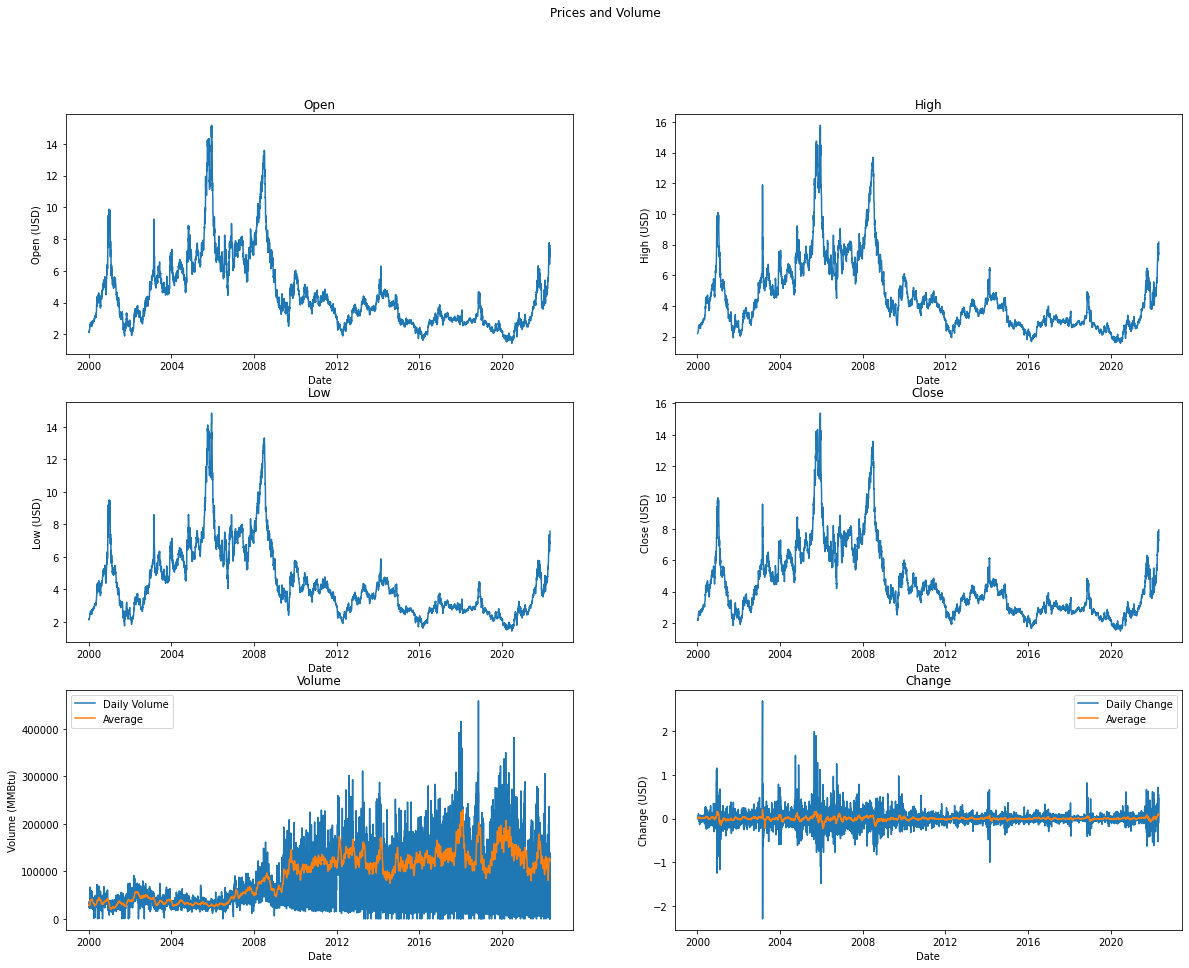

In [42]:
fig, axes = plt.subplots(3,2, figsize=(20,15))
axes = axes.flatten()
for i, feature in enumerate(df.columns[1:-1]):
    sns.lineplot(data=df, x='Date', y=feature, ax=axes[i])
    axes[i].set_title(feature)
    if feature != 'Volume':
        axes[i].set_ylabel(f'{feature} (USD)')
    elif feature == 'Volume':
        axes[i].set_ylabel(f'{feature} (MMBtu)')
    if feature == 'Volume' or feature == 'Change':
        sns.lineplot(data=df, x='Date', y=make_rolling_average(feature), ax=axes[i])
        axes[i].legend(labels=[f'Daily {feature}', f'Average'])
plt.suptitle('Prices and Volume')
plt.show()

### Sign of Change in High Prices Over Time

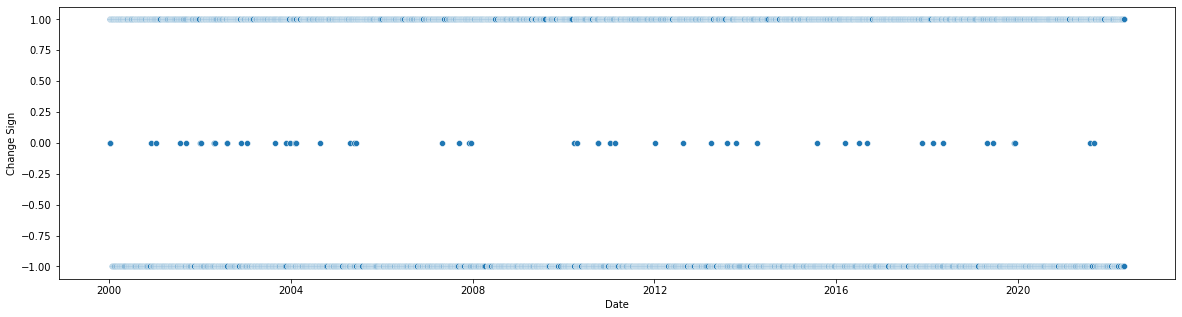

In [11]:
plt.figure(figsize=(20,5))
sns.scatterplot(data=df, x='Date', y='Change Sign')
plt.show()

All that can really be gleaned from the above plot is that prices tend to go either up or down, rather than stay the same. This is unsurprising.

## Price, High Price Change and Volume Distributions

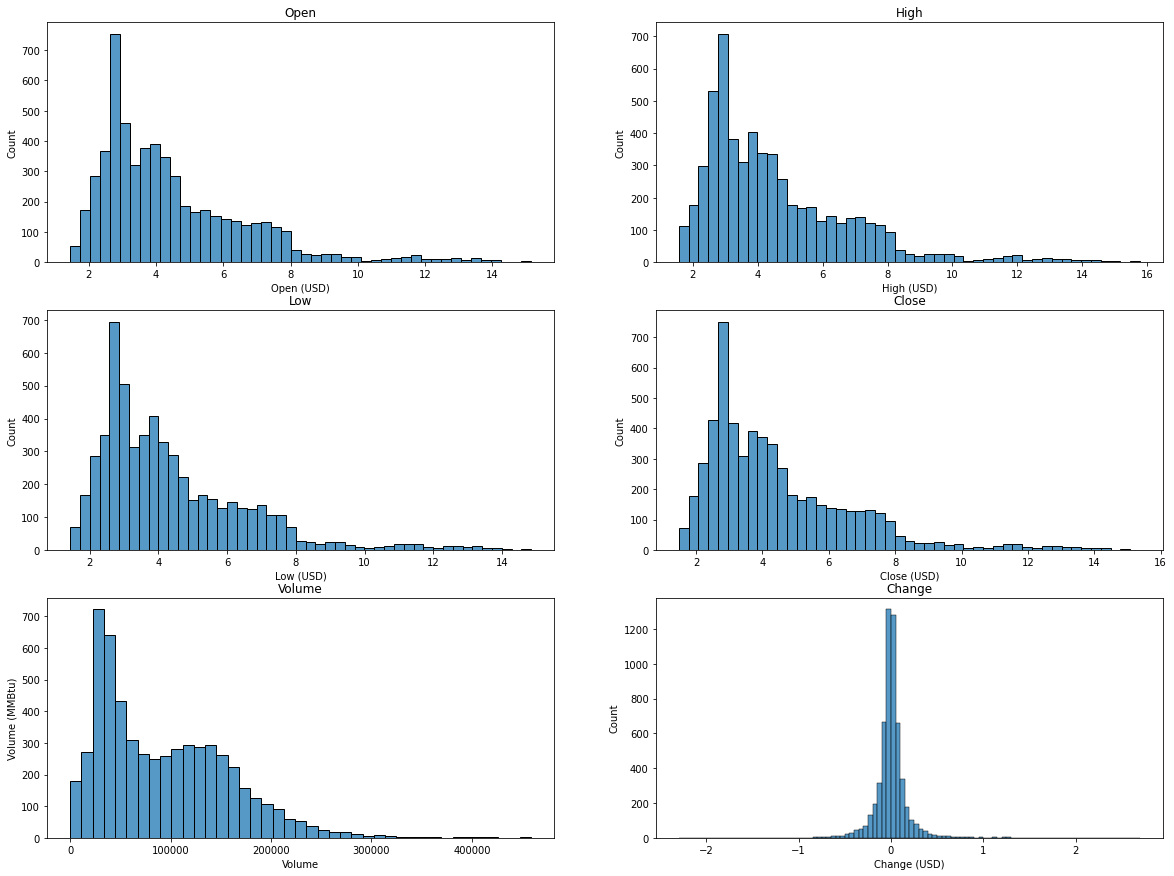

In [43]:
fig, axes = plt.subplots(3,2, figsize=(20,15))
axes = axes.flatten()
for i, feature in enumerate(df.columns[1:-1]):
    axes[i].set_title(feature)
    if feature != 'Volume':
        axes[i].set_xlabel(f'{feature} (USD)')
    elif feature == 'Volume':
        axes[i].set_ylabel(f'{feature} (MMBtu)')

    if feature == 'Change':
        sns.histplot(data=df,x=feature, ax=axes[i], bins=100)
    else:
        sns.histplot(data=df,x=feature, ax=axes[i])

In [13]:
change_std = df['Change'].std()
change_mean = df['Change'].mean()
print(f'The standard deviation for the daily change distribution is ${np.round(change_std, decimals=3)}, and its mean is {np.round(change_mean, decimals=3)}.')

The standard deviation for the daily change distribution is $0.179, and its mean is 0.001.


None of the distributions appear to be normal. None are symmetrical, with the exception of possibly the daily change in price. None of this is surprising. All of the distributions are similarly shaped. Given that the change in USD are mostly under about $0.50, this is an unsurprising result with respect to prices. However the daily volume, while not distributed identically to the prices, also peaks shortly before zero, followed by a long tail, similarly to the price distributions.

## Correlations

<AxesSubplot:>

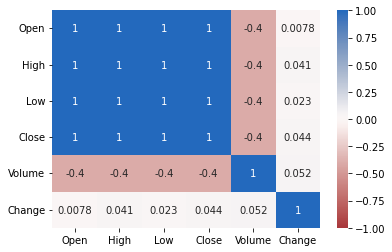

In [14]:
corr = df[df.columns[1:-1]].corr()
div_palette = sns.color_palette("vlag_r", as_cmap=True)
sns.heatmap(data=corr, annot=True, vmin=-1, vmax=1, cmap=div_palette)

Here, there are more expected results: prices correlate highly with each other. The volume correlates negatively with prices. Change in price does not correlate much at all with anything else.

## Change in Sign

### Distribution

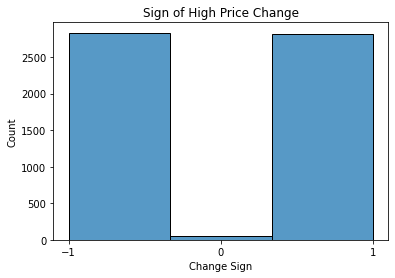

There are 2822 price increases, accounting for 49.44% of price changes
There are 2833 price decreases, accounting for 49.63% of price changes
There are 53 price decreases, accounting for 0.93% of price changes


In [15]:
positive_changes = df[df['Change Sign'] == 1].shape[0]
negative_changes = df[df['Change Sign'] == -1].shape[0]
no_changes = df[df['Change Sign'] == 0].shape[0]
total_changes = df.shape[0]

sns.histplot(data=df, x='Change Sign', bins=3)
plt.title('Sign of High Price Change')
plt.xticks([-1,0,1])
plt.show()

print(f'There are {positive_changes} price increases, accounting for {np.round(100* positive_changes/total_changes, decimals=2)}% of price changes')
print(f'There are {negative_changes} price decreases, accounting for {np.round(100* negative_changes/total_changes, decimals=2)}% of price changes')
print(f'There are {no_changes} price decreases, accounting for {np.round(100* no_changes/total_changes, decimals=2)}% of price changes')

### Direction of Change with Respect to Other Features

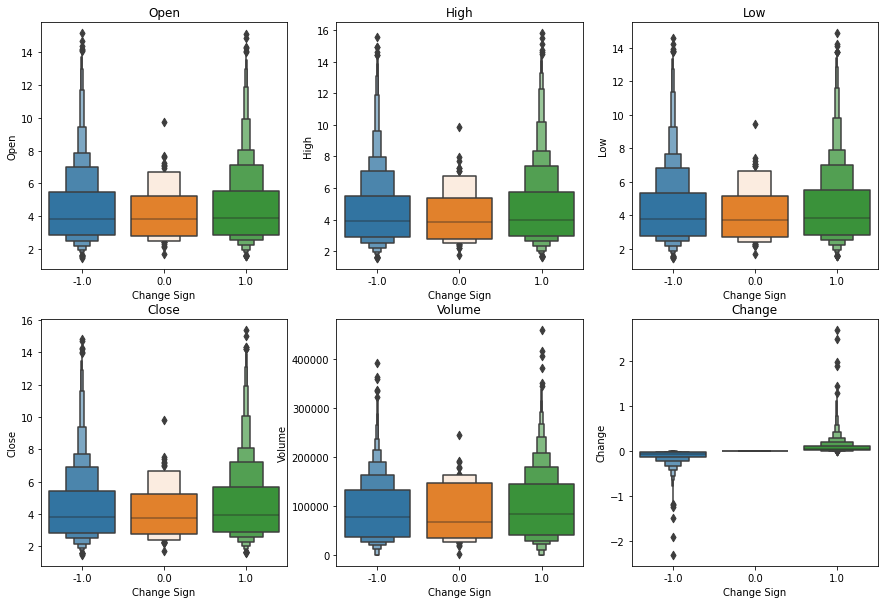

In [16]:
fig, axes = plt.subplots(2,3, figsize=(15,10))
axes = axes.flatten()
for i, feature in enumerate(df.columns[1:-1]):
    sns.boxenplot(data=df, x='Change Sign', y=feature, ax=axes[i])
    axes[i].set_title(feature)

Similarly to the change in price itself, there does not seem to be much relationship between prices, volumes and the direction of the price change. The exception is a relation with the change in price itself, which is, of course, trivial.

# Price Prediction
Prices are predicted using an LSTM

## Split the data

In [17]:
df.head(6)

,Date,Open,High,Low,Close,Volume,Change,Change Sign
0,2000-01-04,2.130,2.200,2.130,2.176,30152,0.000,0.0
1,2000-01-05,2.180,2.200,2.125,2.168,27946,0.000,0.0
2,2000-01-06,2.165,2.220,2.135,2.196,29071,0.020,1.0
3,2000-01-07,2.195,2.230,2.155,2.173,28455,0.010,1.0
4,2000-01-10,2.180,2.255,2.165,2.216,28916,0.025,1.0
5,2000-01-11,2.211,2.265,2.205,2.260,23405,0.010,1.0


In [29]:
# Below four variables will be used to define train and test splits
window_size = 20
train_frac = 0.9
num_samples = df.shape[0] - window_size
train_samples = int(train_frac * num_samples)



values = df[['Open', 'High', 'Low', 'Close', 'Change', 'Volume']].values


# Scale the data to use as input but scale baased only on traaining values
ss = StandardScaler()
train_values_scaled = ss.fit_transform(values[:train_samples])
test_values_scaled = ss.transform(values[train_samples:])
values_scaled = np.concatenate([train_values_scaled, test_values_scaled])

input_seq = []
output_seq = []
for i in range(window_size, values.shape[0]):
    input_seq.append(values_scaled[i-window_size:i])
    output_seq.append(values_scaled[i])

input_seq = np.array(input_seq)
output_seq = np.array(output_seq)


In [30]:
train_frac = 0.9
num_samples = input_seq.shape[0]
train_samples = int(train_frac * num_samples)

x_train = input_seq[:train_samples]
y_train = output_seq[:train_samples]

x_test = input_seq[train_samples:]
y_test = output_seq[train_samples:]

## Build Model

In [31]:
hidden_size = 512
batch_size = 256
dropout_rate = 0.7

In [32]:
inputs = Input(shape=(x_train.shape[1], x_train.shape[2]))

h = LSTM(hidden_size, recurrent_dropout=dropout_rate/2, activation='relu')(inputs)


x = Dense(hidden_size, activation='relu')(h)

x = Dropout(dropout_rate)(x)


outputs = Dense(x_train.shape[2])(x)

model = Model(inputs, outputs)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 6)]           0         
                                                                 
 lstm (LSTM)                 (None, 512)               1062912   
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 6)                 3078      
                                                                 
Total params: 1,328,646
Trainable params: 1,328,646
Non-trainable params: 0
_________________________________________________________________


In [33]:
opt = Adam()
model.compile(optimizer=opt, loss='mae')

model.fit(x_train, y_train, validation_split=0.1, epochs=50, batch_size=batch_size)

Epoch 1/50
18/18 [==============================] - 487s 28s/step - loss: 0.3989 - val_loss: 0.2690
Epoch 2/50
18/18 [==============================] - 20s 1s/step - loss: 0.2828 - val_loss: 0.2039
Epoch 3/50
18/18 [==============================] - 12s 685ms/step - loss: 0.2666 - val_loss: 0.1962
Epoch 4/50
18/18 [==============================] - 84s 5s/step - loss: 0.2592 - val_loss: 0.1982
Epoch 5/50
18/18 [==============================] - 52s 3s/step - loss: 0.2528 - val_loss: 0.2034
Epoch 6/50
18/18 [==============================] - 3s 159ms/step - loss: 0.2507 - val_loss: 0.1966
Epoch 7/50
18/18 [==============================] - 4s 212ms/step - loss: 0.2476 - val_loss: 0.1929
Epoch 8/50
18/18 [==============================] - 3s 197ms/step - loss: 0.2433 - val_loss: 0.1816
Epoch 9/50
18/18 [==============================] - 3s 187ms/step - loss: 0.2413 - val_loss: 0.1864
Epoch 10/50
18/18 [==============================] - 4s 207ms/step - loss: 0.2411 - val_loss: 0.1887
Epoc

# Evaluation

## Mean Absolute Error

In [38]:
y_pred = model.predict(x_test)
y_pred_unscaled = ss.inverse_transform(y_pred)
y_test_unscaled = ss.inverse_transform(y_test)
mae = mean_absolute_error(y_test, y_pred)
mae_unscaled = mean_absolute_error(y_test_unscaled, y_pred_unscaled)


print(f'The mean absolute error on the testing set is is {np.round(mae, decimals=2)}.')
print(f'After inverse transforming the targets and predictions, the mean absolute error increases to {np.round(mae_unscaled, decimals=2)}.')

The mean absolute error on the testing set is is 0.21.
After inverse transforming the targets and predictions, the mean absolute error increases to 6074.45.


In [39]:
y_pred_unscaled[0]

array([ 1.7647657e+00,  1.8115069e+00,  1.7311960e+00,  1.7729423e+00,
       -8.1971576e-03,  1.8240728e+05], dtype=float32)

Using the above prediction as an example, it is safe to make an initial assumption that impropere volume predictions are driving the mean absolute error.

## Visualizations

### Comparing Ground Truth and Predictions
Below, the ground truth values are plotted against predicted values. The ideal plot, one where the predictions are perfect, will thus be a straight line with slope 1. Deviations from such a line are due to poor predictions.

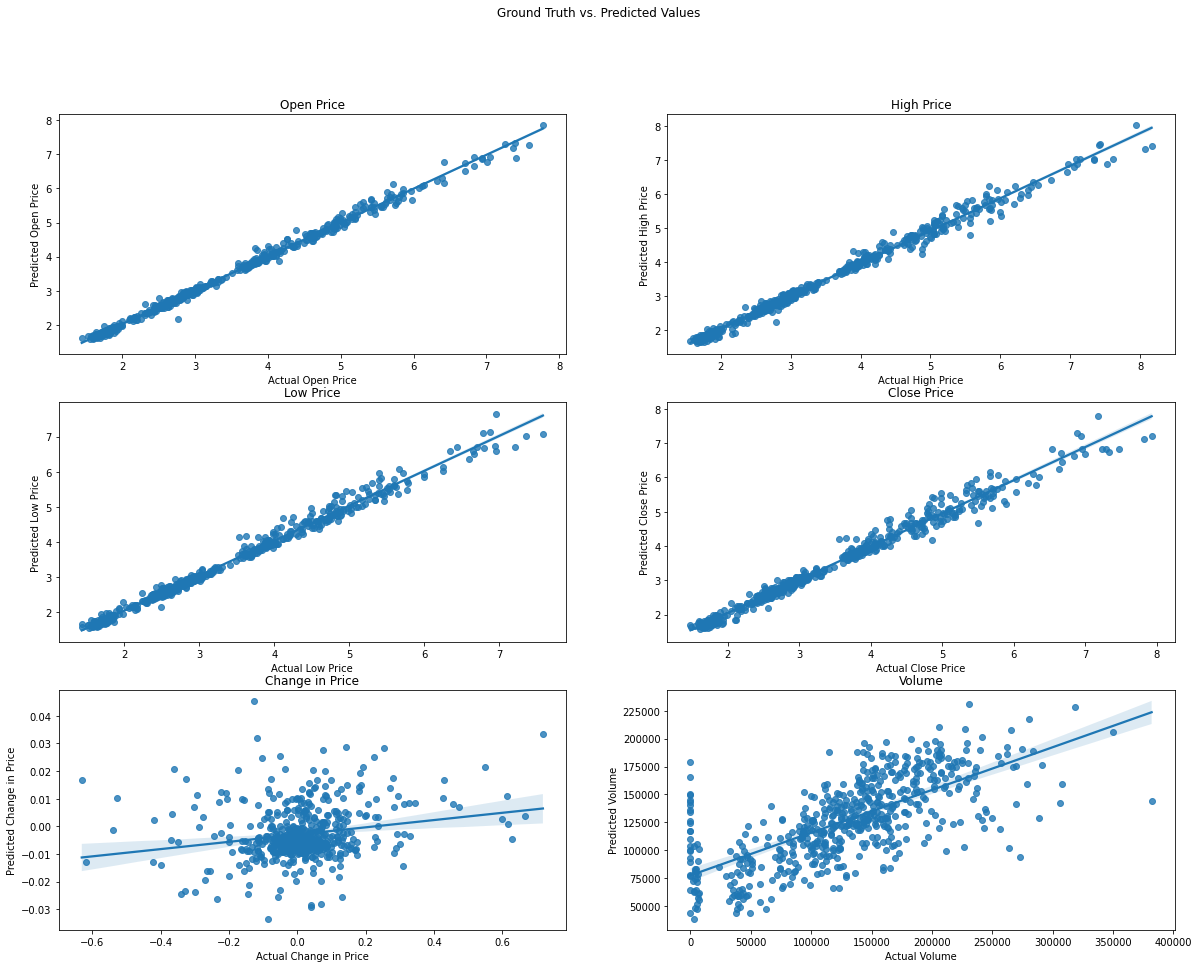

In [40]:
columns = ['Open Price', 'High Price', 'Low Price', 'Close Price', 'Change in Price', 'Volume']
fig, axes = plt.subplots(3,2, figsize=(20,15))
axes = axes.flatten()
fig.suptitle('Ground Truth vs. Predicted Values')
for i in range(y_pred.shape[1]):
    sns.regplot(x=y_test_unscaled[:, i],  y=y_pred_unscaled[:, i], ax=axes[i])
    axes[i].set_xlabel(f'Actual {columns[i]}')
    axes[i].set_ylabel(f'Predicted {columns[i]}')
    axes[i].set_title(columns[i])


Above, there is a linear relationship between all of the predicted and actual prices, suggesting a decent quality of predictions. The changes in price and volumes, however, are not predicted accurately.

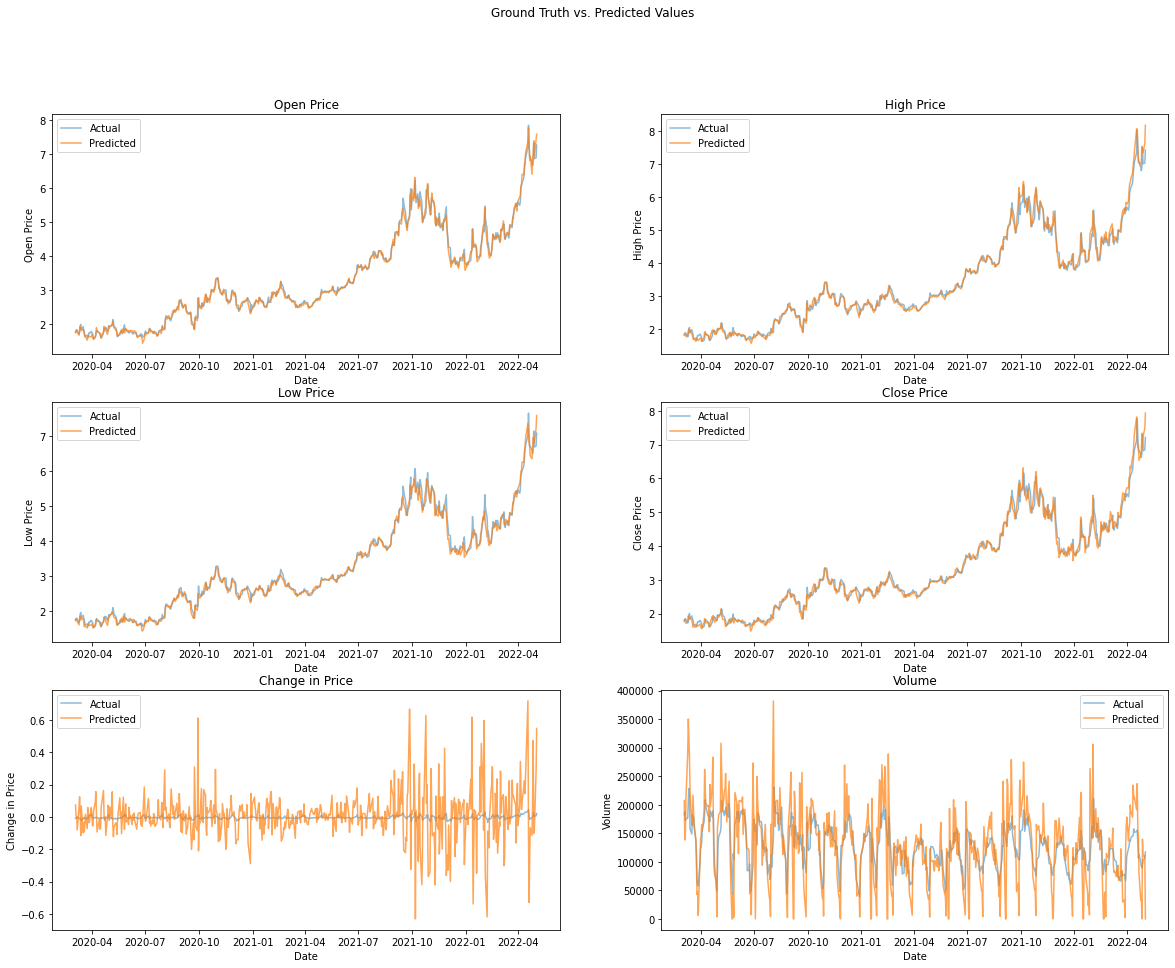

In [41]:
test_dates = df.iloc[window_size + train_samples:]
columns = ['Open Price', 'High Price', 'Low Price', 'Close Price', 'Change in Price', 'Volume']
fig, axes = plt.subplots(3,2, figsize=(20,15))
axes = axes.flatten()
fig.suptitle('Ground Truth vs. Predicted Values')
for i in range(y_pred.shape[1]):
    sns.lineplot(data=test_dates,  x='Date',  y=y_pred_unscaled[:, i], ax=axes[i], alpha=0.5)
    sns.lineplot(data=test_dates, x='Date',  y=y_test_unscaled[:, i], ax=axes[i], alpha=0.7)
    axes[i].set_xlabel(f'Date')
    axes[i].set_ylabel(f'{columns[i]}')
    axes[i].set_title(columns[i])
    axes[i].legend(labels=[f'Actual', f'Predicted'])
plt.show()

The above confirms the conclusions from the prior plots - The model prediccts prices well but struggles to predict changes in price and volume. Further, with respect to price prediction, it would appear that the quality of prediction improves  When considering a higher degree

# Conclusion
The LSTM model is able to predict natural gas prices. However, the model is unable to effectively able to predict volumes of gas or the magnitude of a change (as distinct from predicting new prices). These deficiencies are unconcerning as the primary goal is to predict prices.